<a href="https://colab.research.google.com/github/ngohuy1811/AIO_Module_6/blob/main/Advanced_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!gdown 1fnJMMw0LvDgl-GS4FTou5qAgLxOE2KQ0

Downloading...
From (original): https://drive.google.com/uc?id=1fnJMMw0LvDgl-GS4FTou5qAgLxOE2KQ0
From (redirected): https://drive.google.com/uc?id=1fnJMMw0LvDgl-GS4FTou5qAgLxOE2KQ0&confirm=t&uuid=54aa4c92-cdb9-4b30-886a-737d58f47aa0
To: /content/img_cls_weather_dataset.zip
100% 613M/613M [00:03<00:00, 183MB/s]


In [2]:
import torch
import torch.nn as nn
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [3]:
#Khởi tạo giá trị ngẫu nhiên
#Giá trị ngẫu nhiên đc fix cho bài tập này
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed = 59
set_seed(seed)

In [4]:
!unzip /content/img_cls_weather_dataset.zip


Streaming output truncated to the last 5000 lines.
  inflating: weather-dataset/dataset/frost/3922.jpg  
  inflating: weather-dataset/dataset/frost/3923.jpg  
  inflating: weather-dataset/dataset/frost/3924.jpg  
  inflating: weather-dataset/dataset/frost/3925.jpg  
  inflating: weather-dataset/dataset/frost/3926.jpg  
  inflating: weather-dataset/dataset/frost/3927.jpg  
  inflating: weather-dataset/dataset/frost/3928.jpg  
  inflating: weather-dataset/dataset/frost/3929.jpg  
  inflating: weather-dataset/dataset/frost/3930.jpg  
  inflating: weather-dataset/dataset/frost/3931.jpg  
  inflating: weather-dataset/dataset/frost/3932.jpg  
  inflating: weather-dataset/dataset/frost/3933.jpg  
  inflating: weather-dataset/dataset/frost/3934.jpg  
  inflating: weather-dataset/dataset/frost/3935.jpg  
  inflating: weather-dataset/dataset/frost/3936.jpg  
  inflating: weather-dataset/dataset/frost/3937.jpg  
  inflating: weather-dataset/dataset/frost/3938.jpg  
  inflating: weather-dataset/da

In [5]:
root_dir = '/content/weather-dataset/dataset'
img_paths = []
labels = []
classes = {
    label_idx: class_name \
    for label_idx, class_name in enumerate(os.listdir(root_dir))
}

img_paths = []
labels = []
for label_idx, class_name in classes.items():
    class_dir = os.path.join(root_dir, class_name)
    for img_filename in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_filename)
        img_paths.append(img_path)
        labels.append(label_idx)



In [6]:
#Chia bộ dữ liệu:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    img_paths, labels,
    test_size = val_size,
    random_state=seed,
    shuffle = is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size = val_size,
    random_state=seed,
    shuffle = is_shuffle
)

In [7]:
#Xây dựng class cho Dataset:
class WeatherDataset(Dataset):
    def __init__(
        self,
        X, y,
        transform = None
    ):
        self.transform = transform
        self.img_paths = X
        self.labels = y

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, self.labels[idx]


In [8]:
# Transform function for image preprocessing
def transform(img, img_size =(224 , 224)):
    img = img.resize(img_size) # resize
    img = np.array(img)[..., :3]
    img = torch.tensor(img).permute(2,0,1).float() # to tensor
    normalized_img = img/255.0 #normalize to range (0,1)

    return normalized_img

In [9]:
train_dataset = WeatherDataset(
    X_train, y_train,
    transform = transform
)

val_dataset = WeatherDataset(
    X_val, y_val,
    transform = transform
)

test_dataset = WeatherDataset(
    X_test, y_test,
    transform = transform
)

In [10]:
train_batch_size = 512
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size = train_batch_size,
    shuffle = True
)

val_loader = DataLoader(
    val_dataset,
    batch_size = test_batch_size,
    shuffle = False
)

test_loader = DataLoader(
    test_dataset,
    batch_size = test_batch_size,
    shuffle = False
)

In [11]:
#Resnet model:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels,out_channels, kernel_size =3 , stride =1 , padding =1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.downsample = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn. Conv2d(in_channels, out_channels, kernel_size =1, stride = stride),
                nn.BatchNorm2d(out_channels)
            )
        self.relu = nn.ReLU()
    def forward(self, x):
        shortcut = x. clone()
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x += self.downsample(shortcut)
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, residual_block , n_blocks_lst , n_classes):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64 , kernel_size =7, stride =2,
padding=3)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size =3, stride =2, padding =1)

        self.conv2 = self.create_layer(residual_block, 64, 64, n_blocks_lst[0], 1)
        self.conv3 = self.create_layer(residual_block, 64, 128, n_blocks_lst[1], 2)
        self.conv4 = self.create_layer(residual_block, 128, 256, n_blocks_lst[2], 2)
        self.conv5 = self.create_layer(residual_block, 256, 512, n_blocks_lst[3], 2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512, n_classes)

    def create_layer(self, residual_block, in_channels, out_channels, n_blocks, stride):
        blocks = []
        first_block = residual_block(in_channels, out_channels, stride)
        blocks.append(first_block)
        for _ in range(1, n_blocks):
            block = residual_block(out_channels, out_channels, stride)
            blocks.append(block)
        block_sequential = nn.Sequential(*blocks)

        return block_sequential
    def forward(self , x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.max_pool(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return x

n_classes = len(list(classes.keys()))
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = ResNet(residual_block = ResidualBlock, n_blocks_lst =[2 , 2 , 2 , 2], n_classes = n_classes).to(device)


In [12]:
# Validation function:
def evaluate(model , dataloader , criterion , device ):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs , labels in dataloader:
            inputs , labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs , labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data , 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()


    acc = correct / total
    loss = np.mean(losses)
    return acc, loss

In [16]:
#Training function:

def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx,(inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = np.mean(batch_train_losses)
        train_losses.append(train_loss)

        val_acc, val_loss = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        print (f'EPOCH {epoch+1}:\tTrain loss : {train_loss :.4f}\tVal loss: {val_loss :.4f}')

    return train_losses, val_losses


In [17]:
#Parameter, loss & Optimizer
lr = 1e-2
epochs = 25
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)


In [18]:
#Training
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
)

EPOCH 1:	Train loss : 1.3071	Val loss: 2.3894
EPOCH 2:	Train loss : 1.0268	Val loss: 2.3764
EPOCH 3:	Train loss : 0.8343	Val loss: 2.0827
EPOCH 4:	Train loss : 0.7155	Val loss: 1.4244
EPOCH 5:	Train loss : 0.5437	Val loss: 1.4542
EPOCH 6:	Train loss : 0.4082	Val loss: 1.1299
EPOCH 7:	Train loss : 0.2980	Val loss: 1.1336
EPOCH 8:	Train loss : 0.2460	Val loss: 1.0805
EPOCH 9:	Train loss : 0.1724	Val loss: 1.1729
EPOCH 10:	Train loss : 0.1273	Val loss: 1.0051
EPOCH 11:	Train loss : 0.1017	Val loss: 0.9853
EPOCH 12:	Train loss : 0.0769	Val loss: 0.9948
EPOCH 13:	Train loss : 0.0733	Val loss: 0.9904
EPOCH 14:	Train loss : 0.0522	Val loss: 0.9721
EPOCH 15:	Train loss : 0.0411	Val loss: 0.9744
EPOCH 16:	Train loss : 0.0361	Val loss: 0.9879
EPOCH 17:	Train loss : 0.0321	Val loss: 0.9856
EPOCH 18:	Train loss : 0.0277	Val loss: 0.9817
EPOCH 19:	Train loss : 0.0249	Val loss: 0.9843
EPOCH 20:	Train loss : 0.0220	Val loss: 0.9849
EPOCH 21:	Train loss : 0.0200	Val loss: 0.9887
EPOCH 22:	Train loss :

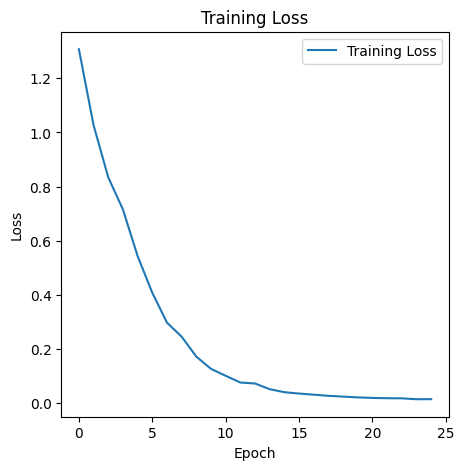

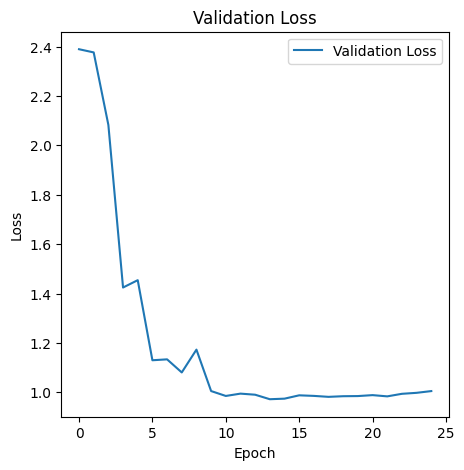

In [19]:
import matplotlib.pyplot as plt


# Plot training loss
plt.figure(figsize=(5, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

# Plot validation loss
plt.figure(figsize=(5, 5))
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.show()

In [20]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device)

test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device)

print ('Evaluation on val / test dataset')
print ('Val accuracy : ', val_acc )
print ('Test accuracy : ', test_acc )

Evaluation on val / test dataset
Val accuracy :  1.005059321345978
Test accuracy :  1.0208857637168705


# **Scenes Classification**

In [21]:
!gdown 1ZUCuYDOe4VVbZvNVZovpquaRQqqJQ639

Downloading...
From (original): https://drive.google.com/uc?id=1ZUCuYDOe4VVbZvNVZovpquaRQqqJQ639
From (redirected): https://drive.google.com/uc?id=1ZUCuYDOe4VVbZvNVZovpquaRQqqJQ639&confirm=t&uuid=be108861-1670-46a3-b402-e4c0ceaa66b9
To: /content/img_cls_scenes_classification.zip
100% 255M/255M [00:01<00:00, 192MB/s]


In [24]:
!unzip /content/img_cls_scenes_classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: scenes_classification/train/mountain/16162.jpg  
  inflating: scenes_classification/train/mountain/16173.jpg  
  inflating: scenes_classification/train/mountain/16225.jpg  
  inflating: scenes_classification/train/mountain/16322.jpg  
  inflating: scenes_classification/train/mountain/16341.jpg  
  inflating: scenes_classification/train/mountain/16350.jpg  
  inflating: scenes_classification/train/mountain/16374.jpg  
  inflating: scenes_classification/train/mountain/16375.jpg  
  inflating: scenes_classification/train/mountain/16417.jpg  
  inflating: scenes_classification/train/mountain/1642.jpg  
  inflating: scenes_classification/train/mountain/16421.jpg  
  inflating: scenes_classification/train/mountain/16438.jpg  
  inflating: scenes_classification/train/mountain/16560.jpg  
  inflating: scenes_classification/train/mountain/16599.jpg  
  inflating: scenes_classification/train/mountain/16645.jpg  
  inflating: scenes_

In [25]:
import torch
import torch.nn as nn
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [26]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed = 59
set_seed(seed)

In [27]:
root_dir = '/content/scenes_classification'
train_dir = os.path.join(root_dir, 'train')
test_dir = os.path.join(root_dir, 'val')

classes = {
    label_idx: class_name \
    for label_idx, class_name in enumerate(os.listdir(train_dir))
}

In [28]:
X_train = []
y_train = []
X_test = []
y_test = []

for dataset_path in[train_dir, test_dir]:
    for label_idx, class_name in classes.items():
        class_dir = os.path.join(dataset_path, class_name)
        for img_filename in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_filename)
            if 'train' in dataset_path:
                X_train.append(img_path)
                y_train.append(label_idx)
            else:
                X_test.append(img_path)
                y_test.append(label_idx)

In [29]:
seed = 0
val_size = 0.2
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size = val_size,
    random_state=seed,
    shuffle = is_shuffle
)

In [30]:
class ScenesDataset(Dataset):
    def __init__(
        self,
        X, y,
        transform = None
    ):
        self.transform = transform
        self.img_paths = X
        self.labels = y

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, self.labels[idx]


In [31]:
def transform(img, img_size=(224,224)):
    img = img.resize(img_size) # resize
    img = np.array(img)[..., :3]
    img = torch.tensor(img).permute(2,0,1).float() # to tensor
    normalized_img = img/255.0

    return normalized_img

In [32]:
train_dataset = ScenesDataset(
    X_train, y_train,
    transform = transform
)

val_dataset = ScenesDataset(
    X_val, y_val,
    transform = transform
)

test_dataset = ScenesDataset(
    X_test, y_test,
    transform = transform
)

In [33]:
train_batch_size = 64
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size = train_batch_size,
    shuffle = True
)

val_loader = DataLoader(
    val_dataset,
    batch_size = test_batch_size,
    shuffle = False
)

test_loader = DataLoader(
    test_dataset,
    batch_size = test_batch_size,
    shuffle = False
)

In [34]:
class BottleneckBlock (nn.Module):
    def __init__ (self, in_channels, growth_rate):
        super(BottleneckBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, 4 * growth_rate, kernel_size = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(4 * growth_rate)
        self.conv2 = nn.Conv2d(4 * growth_rate, growth_rate, kernel_size = 3, padding = 1, bias = False)
        self.relu = nn.ReLU(inplace = True)

    def forward(self, x):
        res = x.clone().detach()
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = torch.cat((res, x), 1)

        return x

class DenseBlock(nn.Module):
    def __init__(self , num_layers , in_channels , growth_rate):
        super(DenseBlock, self).__init__()
        layers = []
        for i in range(num_layers):
            layers.append(BottleneckBlock(in_channels + i * growth_rate, growth_rate))
            self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

class DenseNet(nn.Module):
    def __init__ (self, num_blocks, growth_rate, num_classes):
        super(DenseNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 2 * growth_rate, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(2*growth_rate)
        self.pool1 = nn.MaxPool2d(kernel_size=3 , stride =2 , padding =1)

        self.dense_blocks = nn.ModuleList()
        in_channels = 2 * growth_rate
        for i, num_layers in enumerate(num_blocks):
            self.dense_blocks.append(DenseBlock(num_layers, in_channels, growth_rate))
            in_channels += num_layers * growth_rate
            if i != len(num_blocks) - 1:
                out_channels = in_channels // 2
                self.dense_blocks.append(nn.Sequential(nn.BatchNorm2d(in_channels),
                                                       nn.Conv2d(in_channels , out_channels, kernel_size
=1 , bias = False),
                                                      nn.AvgPool2d(kernel_size=2, stride =2)))
                in_channels = out_channels

        self.bn2 = nn.BatchNorm2d(in_channels)
        self.pool2 = nn.AvgPool2d(kernel_size=7)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(in_channels, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool1(x)

        for block in self.dense_blocks:
            x = block(x)

        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [35]:
n_classes = len(list(classes.keys()))
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = DenseNet(num_blocks=[6, 12, 24, 16], growth_rate=32, num_classes=n_classes).to(device)

In [36]:
lr = 1e-2
epochs = 15
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [37]:
train_losses , val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
)

EPOCH 1:	Train loss : 1.4422	Val loss: 1.2557
EPOCH 2:	Train loss : 1.2114	Val loss: 1.1451
EPOCH 3:	Train loss : 1.1270	Val loss: 1.0870
EPOCH 4:	Train loss : 1.0712	Val loss: 1.0223
EPOCH 5:	Train loss : 1.0159	Val loss: 0.9674
EPOCH 6:	Train loss : 0.9705	Val loss: 0.9236
EPOCH 7:	Train loss : 0.9220	Val loss: 0.8708
EPOCH 8:	Train loss : 0.8703	Val loss: 0.8378
EPOCH 9:	Train loss : 0.8373	Val loss: 0.7971
EPOCH 10:	Train loss : 0.7940	Val loss: 0.7706
EPOCH 11:	Train loss : 0.7576	Val loss: 0.7274
EPOCH 12:	Train loss : 0.7241	Val loss: 0.7211
EPOCH 13:	Train loss : 0.6932	Val loss: 0.7124
EPOCH 14:	Train loss : 0.6596	Val loss: 0.6793
EPOCH 15:	Train loss : 0.6318	Val loss: 0.6932


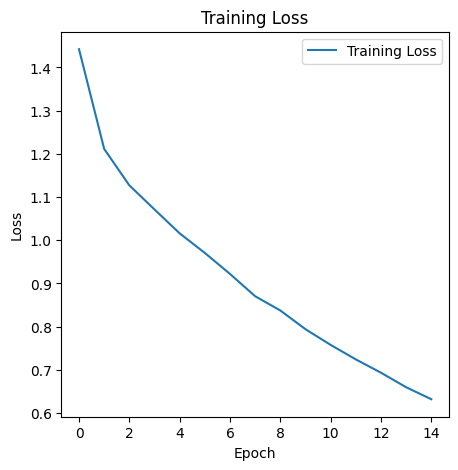

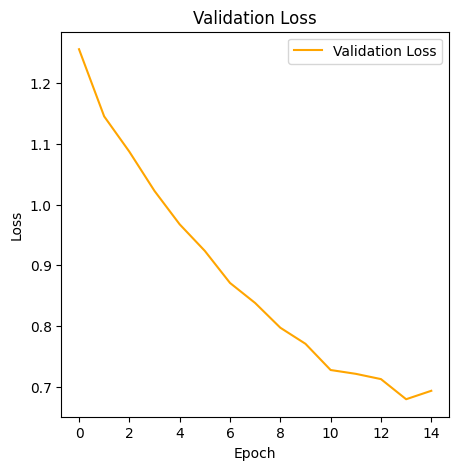

In [38]:
import matplotlib.pyplot as plt


# Plot training loss
plt.figure(figsize=(5, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

# Plot validation loss
plt.figure(figsize=(5, 5))
plt.plot(val_losses, label='Validation Loss', color = 'orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.show()

In [39]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device)

test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device)

print ('Evaluation on val / test dataset')
print ('Val accuracy : ', val_acc )
print ('Test accuracy : ', test_acc )

Evaluation on val / test dataset
Val accuracy :  0.6932106396326652
Test accuracy :  0.7083463596751293


# **Multiple Choice**

In [1]:
import torch
import torch.nn as nn
import numpy as np

data = np.array([[[1 , 6] , [3 , 4]]])
data = torch.tensor(data, dtype = torch.float32)

bnorm = nn.BatchNorm2d(1)
data = data.unsqueeze(0)
with torch.no_grad():
    output = bnorm(data)
    print(output)

#1a

tensor([[[[-1.3867,  1.3867],
          [-0.2773,  0.2773]]]])


In [2]:
import torch

a = torch.tensor([[1 , 2] , [3 , 4]])
b = torch.tensor([[1 , 2] , [3 , 4]])

a = a.reshape(1 , 2 , 2)
b = b.reshape(1 , 2 , 2)

c = torch.cat((a , b))
print(c)
#2c

tensor([[[1, 2],
         [3, 4]],

        [[1, 2],
         [3, 4]]])


In [3]:
#3a
import torch
import torch.nn as nn

seed = 1
torch.manual_seed(seed)
input_tensor = torch.tensor([[[[1.0 , 2.0] , [3.0 , 4.0]]]])

conv_layer = nn.Conv2d( in_channels =1 , out_channels =1 , kernel_size =1)
conv_output = conv_layer(input_tensor)

with torch.no_grad():
    output = conv_output + input_tensor
    print(output)

#4d
#5d
#6b
#7d
#8b

tensor([[[[1.0739, 2.5891],
          [4.1044, 5.6197]]]])
